<a href="https://colab.research.google.com/github/raquelcarmo/tropical_cyclones/blob/main/src/code/TC_model_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# getting in the directory 
%cd /content/drive/My Drive/ESRIN_PhiLab/Tropical_Cyclones/data
%ls

/content/drive/My Drive/ESRIN_PhiLab/Tropical_Cyclones/data
ARCHER/                                SAR_swath_images_VV+VH+VH/
best_track/                            SAR_swath_images_VV+VH+WS/
categorisation.png                     SAR_swath_images_VV+VH+WS_dilated/
download_files.ipynb                   SAR_swath_images_VV+VV+VV/
identification.png                     SAR_swath_images_WS+sWSO+cWSO/
model_comparisons_between_datasets/    SAR_swath_images_WS+WS+WS/
model.png                              SAR_swath_masks/
parametric_model/                      SAR_swath_nc/
SAR_IMAGE_DATASET_EYE_CLASSIFICATION@  SAR_swath_Vmax/
SAR_swath_images_VH+VH+VH/


In [3]:
# general imports
import random
import glob
import os
import sys
sys.stdout.flush()
import pandas as pd
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import imageio
import os.path
from PIL import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import ndimage
from google.colab.patches import cv2_imshow
import random
from shapely.geometry import Point
import re
import pickle
import scipy
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import datetime
from IPython.display import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.layers import concatenate, Dense, GlobalAveragePooling2D
import itertools
import seaborn as sns

## 1. Comparison between X models in one dataset

In [ ]:
# COMPARISON BETWEEN X MODELS
main_dir = "SAR_swath_images_VV+VH+WS_dilated/"
sub_dir = main_dir + "classification_results/categorization/"

# note that the result (in this case the recall) could be null if the classifier is broken 
# (all recall = 1 because is always classified as positive class)
MODEL_1_DIRECTORY = sub_dir + "ResNet_nu-F_bs-8_288x288_lr-0.0001_ep-20_sp-5_no-zT_cr-u1_ag-T/csv"
MODEL_2_DIRECTORY = sub_dir + "ResNet_nu-F_bs-8_352x352_lr-0.0001_ep-20_sp-5_no-zT_cr-u1_ag-T/csv"
MODEL_3_DIRECTORY = sub_dir + "ResNet_nu-F_bs-8_384x384_lr-0.0001_ep-20_sp-5_no-zT_cr-u1_ag-T/csv"
MODEL_4_DIRECTORY = sub_dir + "ResNet_nu-F_bs-8_416x416_lr-0.0001_ep-20_sp-5_no-zT_cr-u1_ag-T/csv"

dir_dict = {1: MODEL_1_DIRECTORY, 2: MODEL_2_DIRECTORY, 3: MODEL_3_DIRECTORY, 4: MODEL_4_DIRECTORY}

# Settings
models = 4
save_plot = False
title = "Comparison between input sizes - ResNet_nu-F_bs-8_XXX_lr-0.0001_ep-20_sp-5_no-zT_cr-u1_ag-T"
file_name = title.replace(" ", "_")

# Critical t-value to see the difference in two distribution with 5 samples
criticalTvalue = 1.533      # 80% confidence
#criticalTvalue = 2.132     # 90% confidence
#criticalTvalue = 2.776     # 95% confidence

###1.1. Load functions

In [9]:
def mean_confidence_interval(data, confidence=0.80):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


def compute_f1(dir):
    precision = np.asarray(pickle.load(open(dir + "/test_precision.pkl",  "rb")))
    recall = np.asarray(pickle.load(open(dir + "/test_recall.pkl",  "rb")))
    f1 = 2 * (precision * recall) / (precision + recall)

    with open(dir + '/test_f1-score.pkl', 'wb') as handle:
        pickle.dump(f1.tolist(), handle, protocol=pickle.HIGHEST_PROTOCOL)


def compute_stats(nb_models, dir_dict, metrics):
    inter_dict = {}
    mean_dict = {}
    for metric in metrics:
        metric_dict = {}
        for i in range(1, nb_models+1):
            load_metric = pickle.load(open(dir_dict[i] + "/test_{}.pkl".format(metric),  "rb"))
            metric_dict['model%d_%s' %(i, metric)] = load_metric

            mean, b, u = mean_confidence_interval(load_metric)
            #print(mean, b, u)
            #conf_dict['model%d_%s' %(i, metric)] = [mean, b, u]

            if 'model%d' %(i) in inter_dict:
                inter_dict['model%d' %(i)].append(u - mean)
                mean_dict['model%d' %(i)].append(mean)
            else:
                inter_dict['model%d' %(i)] = [u - mean]
                mean_dict['model%d' %(i)] = [mean]

        #print(inter_dict)
        #print(mean_dict)
        print("---------------- {} analysis ----------------".format(metric.upper()))
        for x, y in itertools.combinations(metric_dict.keys(), 2):
            t, p = scipy.stats.ttest_ind(metric_dict[x], metric_dict[y])
            print("t value {} between {} and {}: {}".format(metric, x, y, t))
            if t > criticalTvalue or t < -criticalTvalue :
                print("Null hypothesis rejected -> there is a significant difference in the two {} distributions".format(metric))
            else:
                print("Null hypothesis not rejected -> I assume that each difference in {} is due to the randomness".format(metric))
        print("-------------------------------------------------")
    return mean_dict, inter_dict


def plot_model_comparisons(nb_models, metrics, dir_dict, mean_dict, inter_dict, sub_dir, title, save_plot):
    # get colors
    colors = sns.color_palette("hls", nb_models)

    fig, ax = plt.subplots(figsize=(15,8))
    index = np.arange(len(metrics))
    bar_width = 0.1
    opacity = 0.8

    for i in range(1, nb_models+1):
        rects = plt.bar(index + (i-1)*bar_width, mean_dict['model%d' %(i)], bar_width, yerr = inter_dict['model%d' %(i)],
                        capsize = 5, alpha = opacity, color = colors[i-1],
                        label = dir_dict[i].split(sep='/')[-2])

    font_size = 15
    font_size_ticks = 13
    plt.ylabel('Scores', fontsize = font_size)
    plt.title(title, fontsize = font_size)
    plt.xticks(index + (nb_models/2-0.5)*bar_width, tuple([name.capitalize() for name in metrics]), fontsize = font_size)
    plt.yticks(fontsize = font_size_ticks)
    plt.legend(loc = 'lower left', prop={'size': font_size})
    plt.grid(True)
    #ax.set_ylim(ymin=0.75)
    plt.tight_layout()
    plt.show()

    # SAVE PLOT
    if save_plot:
        dir = sub_dir + "model_comparisons/"
        os.makedirs(dir, exist_ok=True)
        fig.savefig("{}/{}.jpg".format(dir, title.replace(" ", "_")), bbox_inches='tight')


def plot_frozen_layers(nb_models, metrics, dir_dict, mean_dict, inter_dict, sub_dir, title, save_plot):
    # get colors
    colors = sns.color_palette("hls", nb_models)
    a = np.arange(nb_models)
    x = [0, 165, 170, 172, 174]
    assert nb_models == len(x)

    fig, ax = plt.subplots(figsize=(15,8))

    for j in range(len(metrics)):
        metric_mean = []
        metric_yerr = []
        for i in range(1, nb_models+1):
            #ax.plot(a, mean_dict['model%d' %(i)], color = colors[i-1], label = dir_dict[i].split(sep='/')[-2])
            metric_mean.append(mean_dict['model%d' %(i)][j])
            metric_yerr.append(inter_dict['model%d' %(i)][j])

        ax.errorbar(a, metric_mean, yerr = metric_yerr, capsize=5, capthick=2,
                    fmt='-o', color = colors[j], label = metrics[j].capitalize())
        bellow = np.asarray(metric_mean)-np.asarray(metric_yerr)
        up = np.asarray(metric_mean)+np.asarray(metric_yerr)
        ax.fill_between(a, bellow.tolist(), up.tolist(), color=colors[j], alpha=.1)
    
    font_size = 15
    font_size_ticks = 13
    plt.xlabel('Number of frozen layers in backbone', fontsize = font_size)
    plt.ylabel('Scores', fontsize = font_size)
    plt.title(title, fontsize = font_size)
    ax.xaxis.set_ticks(a) #set the ticks to be a
    ax.xaxis.set_ticklabels(x, fontsize = font_size_ticks) # change the ticks' names to x
    #ax.set_ylim(ymin=0.25)
    #plt.xticks(x, fontsize = font_size_ticks)
    start, end = ax.get_ylim()
    ax.yaxis.set_ticks(np.arange(np.round(start, 1), np.round(end, 1), 0.05))
    plt.yticks(fontsize = font_size_ticks)
    plt.legend(loc = 'lower left', prop={'size': font_size})
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # SAVE PLOT
    if save_plot:
        dir = sub_dir + "model_comparisons/"
        os.makedirs(dir, exist_ok=True)
        fig.savefig("{}/{}.jpg".format(dir, title.replace(" ", "_")), bbox_inches='tight')

###1.2. Metric analysis and plotting

---------------- ACCURACY analysis ----------------
t value accuracy between model1_accuracy and model2_accuracy: 0.4463377466657764
Null hypothesis not rejected -> I assume that each difference in accuracy is due to the randomness
t value accuracy between model1_accuracy and model3_accuracy: -0.11323181974127941
Null hypothesis not rejected -> I assume that each difference in accuracy is due to the randomness
t value accuracy between model1_accuracy and model4_accuracy: 0.11598447528362921
Null hypothesis not rejected -> I assume that each difference in accuracy is due to the randomness
t value accuracy between model2_accuracy and model3_accuracy: -0.5577898614567087
Null hypothesis not rejected -> I assume that each difference in accuracy is due to the randomness
t value accuracy between model2_accuracy and model4_accuracy: -0.42219569394780154
Null hypothesis not rejected -> I assume that each difference in accuracy is due to the randomness
t value accuracy between model3_accuracy a

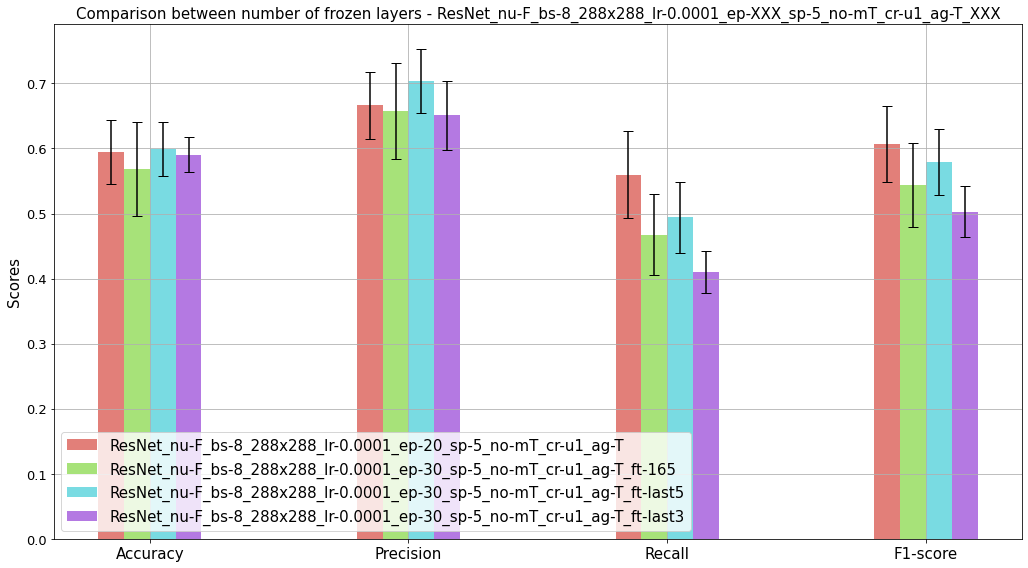

In [ ]:
# compute F1-score if not already computed previously
for i in range(1, models+1):
    dir = dir_dict[i]
    file = glob.glob(dir + '/test_f1-score.pkl')
    if file == []:
        compute_f1(dir)

# metrics to use for analysis
metrics = ["accuracy", "precision", "recall", "f1-score"]
# compute mean and confidence intervals for each metric and each model
mean_dict, inter_dict = compute_stats(models, dir_dict, metrics)
# plot model comparison
plot_model_comparisons(models, metrics, dir_dict, mean_dict, inter_dict, sub_dir, title, save_plot)

###1.3. Plot Scores vs. Nb of frozen layers

In [5]:
main_dir = "SAR_swath_images_VV+VH+WS_dilated/"
sub_dir = main_dir + "classification_results/categorization/"

MODEL_1_DIRECTORY = sub_dir + "ResNet_nu-F_bs-8_288x288_lr-0.0001_ep-20_sp-5_no-mT_cr-u1_ag-T/csv"
MODEL_2_DIRECTORY = sub_dir + "ResNet_nu-F_bs-8_288x288_lr-0.0001_ep-30_sp-5_no-mT_cr-u1_ag-T_ft-165/csv"
MODEL_3_DIRECTORY = sub_dir + "ResNet_nu-F_bs-8_288x288_lr-0.0001_ep-30_sp-5_no-mT_cr-u1_ag-T_ft-last5/csv"
MODEL_4_DIRECTORY = sub_dir + "ResNet_nu-F_bs-8_288x288_lr-0.0001_ep-30_sp-5_no-mT_cr-u1_ag-T_ft-last3/csv"
MODEL_5_DIRECOTRY = sub_dir + "ResNet_nu-F_bs-8_288x288_lr-0.0001_ep-30_sp-5_no-mT_cr-u1_ag-T_ft-last1/csv"

dir_dict = {1: MODEL_1_DIRECTORY, 2: MODEL_2_DIRECTORY, 3: MODEL_3_DIRECTORY, 4: MODEL_4_DIRECTORY, 5: MODEL_5_DIRECOTRY}

# Settings
models = 5
save_plot = False
title = "Comparison between number of frozen layers - ResNet_nu-F_bs-8_288x288_lr-0.0001_ep-XXX_sp-5_no-mT_cr-u1_ag-T_XXX"
file_name = title.replace(" ", "_")

# Critical t-value to see the difference in two distribution with 5 samples
criticalTvalue = 1.533      # 80% confidence
#criticalTvalue = 2.132     # 90% confidence
#criticalTvalue = 2.776     # 95% confidence

---------------- ACCURACY analysis ----------------
t value accuracy between model1_accuracy and model2_accuracy: 0.4463377466657764
Null hypothesis not rejected -> I assume that each difference in accuracy is due to the randomness
t value accuracy between model1_accuracy and model3_accuracy: -0.11323181974127941
Null hypothesis not rejected -> I assume that each difference in accuracy is due to the randomness
t value accuracy between model1_accuracy and model4_accuracy: 0.11598447528362921
Null hypothesis not rejected -> I assume that each difference in accuracy is due to the randomness
t value accuracy between model1_accuracy and model5_accuracy: 0.7794990607751642
Null hypothesis not rejected -> I assume that each difference in accuracy is due to the randomness
t value accuracy between model2_accuracy and model3_accuracy: -0.5577898614567087
Null hypothesis not rejected -> I assume that each difference in accuracy is due to the randomness
t value accuracy between model2_accuracy and

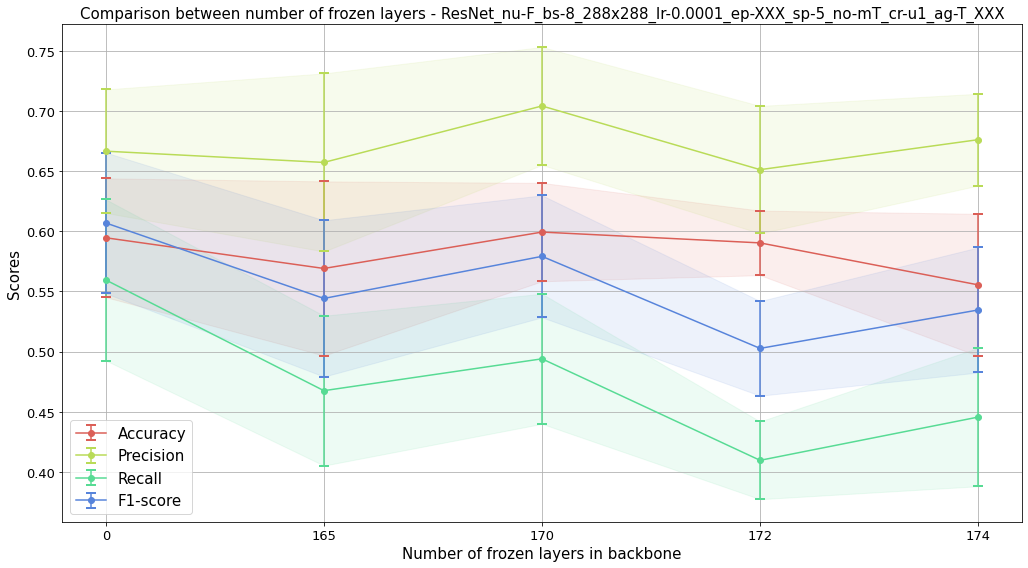

In [10]:
# compute F1-score if not already computed previously
for i in range(1, models+1):
    dir = dir_dict[i]
    file = glob.glob(dir + '/test_f1-score.pkl')
    if file == []:
        print("No f1-score file found.")
        compute_f1(dir)

# metrics to use for analysis
metrics = ["accuracy", "precision", "recall", "f1-score"]
# compute mean and confidence intervals for each metric and each model
mean_dict, inter_dict = compute_stats(models, dir_dict, metrics)
# plot model comparison
plot_frozen_layers(models, metrics, dir_dict, mean_dict, inter_dict, sub_dir, title, save_plot)

###1.4. [DEPRECATED] Metric analysis and plotting

---------------- ACCURACY analysis ----------------
t value accuracy between model1_accuracy and model2_accuracy: -1.0717065852604952
Null hypothesis not rejected -> I assume that each difference in accuracy is due to the randomness
t value accuracy between model1_accuracy and model3_accuracy: 0.923196081485937
Null hypothesis not rejected -> I assume that each difference in accuracy is due to the randomness
t value accuracy between model1_accuracy and model4_accuracy: -0.1886348729626451
Null hypothesis not rejected -> I assume that each difference in accuracy is due to the randomness
t value accuracy between model2_accuracy and model3_accuracy: 1.8650607133594812
Null hypothesis rejected -> there is a significant difference in the two accuracy distributions
t value accuracy between model2_accuracy and model4_accuracy: 0.7054536802444044
Null hypothesis not rejected -> I assume that each difference in accuracy is due to the randomness
t value accuracy between model3_accuracy and model

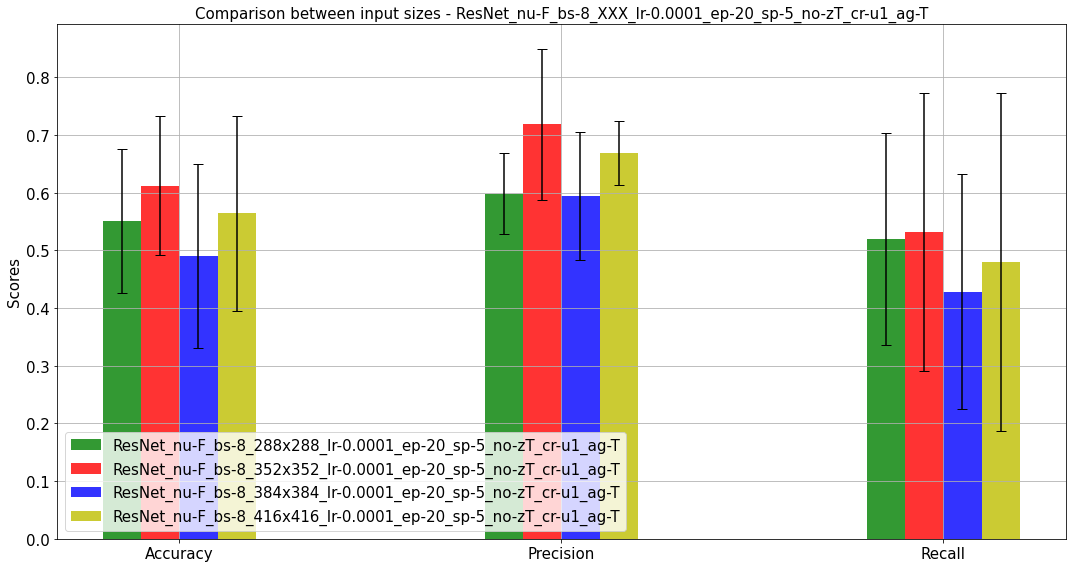

In [ ]:
#[DEPRECATED]
# ACCURACY analysis
model1_accuracy = pickle.load(open(MODEL_1_DIRECTORY + "/test_accuracy.pkl",  "rb" ))
model2_accuracy = pickle.load(open(MODEL_2_DIRECTORY + "/test_accuracy.pkl",  "rb" ))

model1_accuracy_mean, b_model1_acc, u_model1_acc = mean_confidence_interval(model1_accuracy)
model2_accuracy_mean, b_model2_acc, u_model2_acc = mean_confidence_interval(model2_accuracy)

if models > 2:

    model3_accuracy = pickle.load(open(MODEL_3_DIRECTORY + "/test_accuracy.pkl",  "rb" ))
    model4_accuracy = pickle.load(open(MODEL_4_DIRECTORY + "/test_accuracy.pkl",  "rb" ))

    model3_accuracy_mean, b_model3_acc, u_model3_acc = mean_confidence_interval(model3_accuracy)
    model4_accuracy_mean, b_model4_acc, u_model4_acc = mean_confidence_interval(model4_accuracy)

    acc_dict = {"model1_accuracy": model1_accuracy, "model2_accuracy": model2_accuracy, 
                "model3_accuracy": model3_accuracy, "model4_accuracy": model4_accuracy}
    print("---------------- ACCURACY analysis ----------------")
    for x, y in itertools.combinations(acc_dict.keys(), 2):
        t, p = scipy.stats.ttest_ind(acc_dict[x], acc_dict[y])
        print("t value accuracy between {} and {}: {}".format(x, y, t))
        if t > criticalTvalue or t < -criticalTvalue :
            print("Null hypothesis rejected -> there is a significant difference in the two accuracy distributions")
        else:
            print("Null hypothesis not rejected -> I assume that each difference in accuracy is due to the randomness")
    print("-------------------------------------------------")

else:
    print("---------------- ACCURACY analysis ----------------")
    t, p = scipy.stats.ttest_ind(model1_accuracy, model2_accuracy)
    print("t value accuracy: {}".format(t))

    if t > criticalTvalue or t < -criticalTvalue :
        print("Null hypothesis rejected -> there is a significant difference in the two accuracy distributions")
    else:
        print("Null hypothesis not rejected -> I assume that each difference in accuracy is due to the randomness")
    print("-------------------------------------------------")


# PRECISION analysis
model1_precision = pickle.load(open(MODEL_1_DIRECTORY + "/test_precision.pkl",  "rb" ))
model2_precision = pickle.load(open(MODEL_2_DIRECTORY + "/test_precision.pkl",  "rb" ))

model1_precision_mean, b_model1_p, u_model1_p = mean_confidence_interval(model1_precision)
model2_precision_mean, b_model2_p, u_model2_p = mean_confidence_interval(model2_precision)

if models > 2:

    model3_precision = pickle.load(open(MODEL_3_DIRECTORY + "/test_precision.pkl",  "rb" ))
    model4_precision = pickle.load(open(MODEL_4_DIRECTORY + "/test_precision.pkl",  "rb" ))

    model3_precision_mean, b_model3_p, u_model3_p = mean_confidence_interval(model3_precision)
    model4_precision_mean, b_model4_p, u_model4_p = mean_confidence_interval(model4_precision)

    prec_dict = {"model1_precision": model1_precision, "model2_precision": model2_precision, 
                 "model3_precision": model3_precision, "model4_precision": model4_precision}
    print("---------------- PRECISION analysis ----------------")
    for x, y in itertools.combinations(prec_dict.keys(), 2):
        t, p = scipy.stats.ttest_ind(prec_dict[x], prec_dict[y])
        print("t value precision between {} and {}: {}".format(x, y, t))
        if t > criticalTvalue or t < -criticalTvalue :
            print("Null hypothesis rejected -> there is a significant difference in the two precision distributions")
        else:
            print("Null hypothesis not rejected -> I assume that each difference in precision is due to the randomness")
    print("-------------------------------------------------")

else:
    print("---------------- PRECISION analysis ----------------")
    t, p = scipy.stats.ttest_ind(model1_precision, model2_precision)
    print("t value precision: {}".format(t))

    if t > criticalTvalue or t < -criticalTvalue :
        print("Null hypothesis rejected -> there is a significant difference in the two precision distributions")
    else:
        print("Null hypothesis not rejected -> I assume that each difference in precision is due to the randomness")
    print("-------------------------------------------------")
    

# RECALL analysis
model1_recall = pickle.load(open(MODEL_1_DIRECTORY + "/test_recall.pkl",  "rb" ))
model2_recall = pickle.load(open(MODEL_2_DIRECTORY + "/test_recall.pkl",  "rb" ))

model1_recall_mean, b_model1_r, u_model1_r = mean_confidence_interval(model1_recall)
model2_recall_mean, b_model2_r, u_model2_r = mean_confidence_interval(model2_recall)

if models > 2:

    model3_recall = pickle.load(open(MODEL_3_DIRECTORY + "/test_recall.pkl",  "rb" ))
    model4_recall = pickle.load(open(MODEL_4_DIRECTORY + "/test_recall.pkl",  "rb" ))

    model3_recall_mean, b_model3_r, u_model3_r = mean_confidence_interval(model3_recall)
    model4_recall_mean, b_model4_r, u_model4_r = mean_confidence_interval(model4_recall)

    rec_dict = {"model1_recall": model1_recall, "model2_recall": model2_recall, 
                "model3_recall": model3_recall, "model4_recall": model4_recall}
    print("---------------- RECALL analysis ----------------")
    for x, y in itertools.combinations(rec_dict.keys(), 2):
        t, p = scipy.stats.ttest_ind(rec_dict[x], rec_dict[y])
        print("t value recall between {} and {}: {}".format(x, y, t))
        if t > criticalTvalue or t < -criticalTvalue :
            print("Null hypothesis rejected -> there is a significant difference in the two recall distributions")
        else:
            print("Null hypothesis not rejected -> I assume that each difference in recall is due to the randomness")
    print("-------------------------------------------------")

else:
    print("---------------- RECALL analysis ----------------")
    t, p = scipy.stats.ttest_ind(model1_recall, model2_recall)
    print("t value recall: {}".format(t))

    if t > criticalTvalue or t < -criticalTvalue :
        print("Null hypothesis rejected -> there is a significant difference in the two recall distributions")
    else:
        print("Null hypothesis not rejected -> I assume that each difference in recall is due to the randomness")
    print("-------------------------------------------------")


# COMPUTE CONFIDENCE INTERVALS
confidence_model1 = [u_model1_acc - b_model1_acc, u_model1_p - b_model1_p, u_model1_r - b_model1_r]
confidence_model2 = [u_model2_acc - b_model2_acc, u_model2_p - b_model2_p, u_model2_r - b_model2_r]
confidence_model3 = [u_model3_acc - b_model3_acc, u_model3_p - b_model3_p, u_model3_r - b_model3_r]
confidence_model4 = [u_model4_acc - b_model4_acc, u_model4_p - b_model4_p, u_model4_r - b_model4_r]

# DATA TO PLOT
n_groups = 3
means_model1 = (model1_accuracy_mean, model1_precision_mean, model1_recall_mean)
means_model2 = (model2_accuracy_mean, model2_precision_mean, model2_recall_mean)
means_model3 = (model3_accuracy_mean, model3_precision_mean, model3_recall_mean)
means_model4 = (model4_accuracy_mean, model4_precision_mean, model4_recall_mean)

# CREATE PLOT
fig, ax = plt.subplots(figsize=(15,8))
index = np.arange(n_groups)
bar_width = 0.1
opacity = 0.8

rects1 = plt.bar(index, means_model1, bar_width, yerr = confidence_model1, capsize = 5, alpha = opacity, color = 'g',
                 label = MODEL_1_DIRECTORY.split(sep='/')[-2])

rects2 = plt.bar(index + bar_width, means_model2, bar_width, yerr = confidence_model2, capsize = 5, alpha = opacity, color = 'r',
                 label = MODEL_2_DIRECTORY.split(sep='/')[-2])

rects3 = plt.bar(index + 2 * bar_width, means_model3, bar_width, yerr = confidence_model3, capsize = 5, alpha = opacity, color = 'b',
                 label = MODEL_3_DIRECTORY.split(sep='/')[-2])

rects4 = plt.bar(index + 3 * bar_width, means_model4, bar_width, yerr = confidence_model4, capsize = 5, alpha = opacity, color = 'y',
                 label = MODEL_4_DIRECTORY.split(sep='/')[-2])

font_size = 15
font_size_ticks = 15
plt.ylabel('Scores', fontsize = font_size)
plt.title(title, fontsize = font_size)
plt.xticks(index + 1.5*bar_width, ('Accuracy', 'Precision', 'Recall'), fontsize = font_size_ticks)
plt.yticks(fontsize = font_size_ticks)
plt.legend(loc = 'lower left', prop={'size': font_size})
plt.grid(True)
#ax.set_ylim(ymin=0.75)
plt.tight_layout()
plt.show()

# SAVE PLOT
if save_plot:
    dir = sub_dir + "model_comparisons/"
    os.makedirs(dir, exist_ok=True)
    fig.savefig("{}/{}.jpg".format(dir, title), bbox_inches='tight')

###1.5. [DEPRECATED] Plot confusion matrices

In [ ]:
#COMPARE CONFUSION MATRIX
TP_model1 = pickle.load(open(MODEL_1_DIRECTORY + "/test_tp.pkl",  "rb" ))
FP_model1 = pickle.load(open(MODEL_1_DIRECTORY + "/test_fp.pkl",  "rb" ))
TN_model1 = pickle.load(open(MODEL_1_DIRECTORY + "/test_tn.pkl",  "rb" ))
FN_model1 = pickle.load(open(MODEL_1_DIRECTORY + "/test_fn.pkl",  "rb" ))

TP_model2 = pickle.load(open(MODEL_2_DIRECTORY + "/test_tp.pkl",  "rb" ))
FP_model2 = pickle.load(open(MODEL_2_DIRECTORY + "/test_fp.pkl",  "rb" ))
TN_model2 = pickle.load(open(MODEL_2_DIRECTORY + "/test_tn.pkl",  "rb" ))
FN_model2 = pickle.load(open(MODEL_2_DIRECTORY + "/test_fn.pkl",  "rb" ))

fold = 0
for tp_1, fp_1, tn_1, fn_1, tp_2, fp_2, tn_2, fn_2 in zip(TP_model1, FP_model1, TN_model1, FN_model1, TP_model2, FP_model2, TN_model2, FN_model2):
  fold += 1

  print("Model 1 confusion matrix")
  fig, ax = plt.subplots()  
  my_confusion_matrix = [[tp_1, fn_1], [fp_1, tn_1]]
  plt.imshow(my_confusion_matrix, cmap=plt.cm.Blues)
  plt.ylabel("Not present                 Present")
  plt.xticks([], [])
  plt.yticks([], [])
  plt.title("Present                  Not present")
  #plt.colorbar() 
  ax.text(0, 0, int(tp_1), ha="center", va="center", color="black")
  ax.text(1, 0, int(fn_1), ha="center", va="center", color="black")
  ax.text(0, 1, int(fp_1), ha="center", va="center", color="black")
  ax.text(1, 1, int(tn_1), ha="center", va="center", color="black")
  plt.show()

  fig.savefig(MODEL_1_DIRECTORY + "/confusion_matrix_{}.jpg".format(fold))

  print("Model 2 confusion matrix")
  fig, ax = plt.subplots()  
  my_confusion_matrix = [[tp_2, fn_2], [fp_2, tn_2]]
  plt.imshow(my_confusion_matrix, cmap=plt.cm.Blues)
  plt.ylabel("Not present                 Present")
  plt.xticks([], [])
  plt.yticks([], [])
  plt.title("Present                  Not present")
  #plt.colorbar() 
  ax.text(0, 0, int(tp_2), ha="center", va="center", color="black")
  ax.text(1, 0, int(fn_2), ha="center", va="center", color="black")
  ax.text(0, 1, int(fp_2), ha="center", va="center", color="black")
  ax.text(1, 1, int(tn_2), ha="center", va="center", color="black")
  plt.show()

  fig.savefig(MODEL_2_DIRECTORY + "/confusion_matrix_{}.jpg".format(fold))

  """
  print("Fold {}:    Model 1                     Model 2".format(fold))
  fig, (ax1, ax2) = plt.subplots(1, 2)
  my_confusion_matrix = [[tp_1, fn_1], [fp_1, tn_1]]
  ax1.imshow(my_confusion_matrix, cmap=plt.cm.Blues)
  ax1.set(ylabel = "Not present                 Present",
          title = "   Present          Not present")
  ax1.set_xticks([])
  ax1.set_yticks([])
  #plt.colorbar() 
  ax1.text(0, 0, int(tp_1), ha="center", va="center", color="black")
  ax1.text(1, 0, int(fn_1), ha="center", va="center", color="black")
  ax1.text(0, 1, int(fp_1), ha="center", va="center", color="black")
  ax1.text(1, 1, int(tn_1), ha="center", va="center", color="black")

  my_confusion_matrix = [[tp_2, fn_2], [fp_2, tn_2]]
  ax2.imshow(my_confusion_matrix, cmap=plt.cm.Blues)
  ax2.set(ylabel = "Not present                 Present",
          title = "   Present           Not present")
  ax2.set_xticks([])
  ax2.set_yticks([])
  #plt.colorbar() 
  ax2.text(0, 0, int(tp_2), ha="center", va="center", color="black")
  ax2.text(1, 0, int(fn_2), ha="center", va="center", color="black")
  ax2.text(0, 1, int(fp_2), ha="center", va="center", color="black")
  ax2.text(1, 1, int(tn_2), ha="center", va="center", color="black")
  plt.tight_layout()
  plt.show()
  """

## 2. Comparison between 6 models across datasets

In [ ]:
# COMPARISON BETWEEN FOUR MODELS
NETWORK = "Mobile"
models = 6
MODEL_1_DIRECTORY = "SAR_swath_images_VV+VH+WS/classification_results/categorization/{}_Numeric-F_BatchSize-8_lr-0.0001_Epochs-20_Folds-5_Norm-T_Aug-T/csv".format(NETWORK)
MODEL_2_DIRECTORY = "SAR_swath_images_VV+VH+VH/classification_results/categorization/{}_Numeric-F_BatchSize-8_lr-0.0001_Epochs-20_Folds-5_Norm-T_Aug-T/csv".format(NETWORK)
MODEL_3_DIRECTORY = "SAR_swath_images_WS+WS+WS/classification_results/categorization/{}_Numeric-F_BatchSize-8_lr-0.0001_Epochs-20_Folds-5_Norm-T_Aug-T/csv".format(NETWORK)
MODEL_4_DIRECTORY = "SAR_swath_images_WS+sWSO+cWSO/classification_results/categorization/{}_Numeric-F_BatchSize-8_lr-0.0001_Epochs-20_Folds-5_Norm-T_Aug-T/csv".format(NETWORK)
MODEL_5_DIRECTORY = "SAR_swath_images_VV+VV+VV/classification_results/categorization/{}_Numeric-F_BatchSize-8_700x400_lr-0.0001_Epochs-20_Folds-5_Norm-T_Aug-T/csv".format(NETWORK)
MODEL_6_DIRECTORY = "SAR_swath_images_VH+VH+VH/classification_results/categorization/{}_Numeric-F_BatchSize-8_700x400_lr-0.0001_Epochs-20_Folds-5_Norm-T_Aug-T/csv".format(NETWORK)

---------------- ACCURACY analysis ----------------
t value accuracy between model1_accuracy and model2_accuracy: 0.862011490004083
Null hypothesis not rejected -> I assume that each difference in accuracy is due to the randomness
t value accuracy between model1_accuracy and model3_accuracy: 2.39871571471815
Null hypothesis rejected -> there is a significant difference in the two accuracy distributions
t value accuracy between model1_accuracy and model4_accuracy: 6.625554434798109
Null hypothesis rejected -> there is a significant difference in the two accuracy distributions
t value accuracy between model1_accuracy and model5_accuracy: 0.4355696062238401
Null hypothesis not rejected -> I assume that each difference in accuracy is due to the randomness
t value accuracy between model1_accuracy and model6_accuracy: 0.42413675812356094
Null hypothesis not rejected -> I assume that each difference in accuracy is due to the randomness
t value accuracy between model2_accuracy and model3_accur

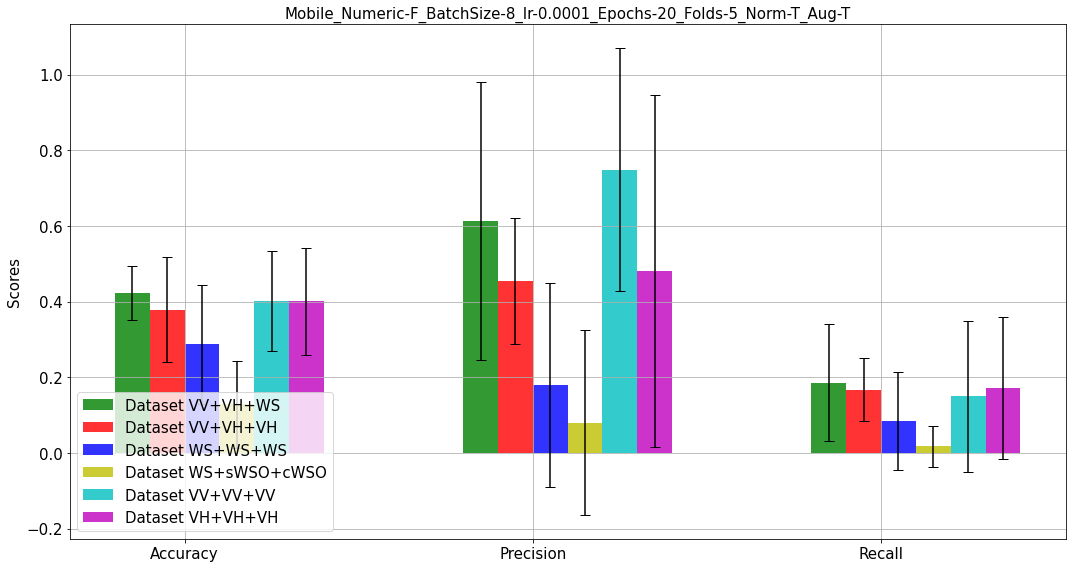

In [ ]:
# Critical t-value to see the difference in two distribution with 5 samples
# 80% confidence
criticalTvalue = 1.533

# 90% confidence
#criticalTvalue = 2.132

# 95% confidence
#criticalTvalue = 2.776


def mean_confidence_interval(data, confidence=0.80):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


# ACCURACY analysis
model1_accuracy = pickle.load(open(MODEL_1_DIRECTORY + "/test_accuracy.pkl",  "rb" ))
model2_accuracy = pickle.load(open(MODEL_2_DIRECTORY + "/test_accuracy.pkl",  "rb" ))
model3_accuracy = pickle.load(open(MODEL_3_DIRECTORY + "/test_accuracy.pkl",  "rb" ))
model4_accuracy = pickle.load(open(MODEL_4_DIRECTORY + "/test_accuracy.pkl",  "rb" ))
model5_accuracy = pickle.load(open(MODEL_5_DIRECTORY + "/test_accuracy.pkl",  "rb" ))
model6_accuracy = pickle.load(open(MODEL_6_DIRECTORY + "/test_accuracy.pkl",  "rb" ))

model1_accuracy_mean, b_model1_acc, u_model1_acc = mean_confidence_interval(model1_accuracy)
model2_accuracy_mean, b_model2_acc, u_model2_acc = mean_confidence_interval(model2_accuracy)
model3_accuracy_mean, b_model3_acc, u_model3_acc = mean_confidence_interval(model3_accuracy)
model4_accuracy_mean, b_model4_acc, u_model4_acc = mean_confidence_interval(model4_accuracy)
model5_accuracy_mean, b_model5_acc, u_model5_acc = mean_confidence_interval(model5_accuracy)
model6_accuracy_mean, b_model6_acc, u_model6_acc = mean_confidence_interval(model6_accuracy)

import itertools
acc_dict = {"model1_accuracy": model1_accuracy, "model2_accuracy": model2_accuracy, "model3_accuracy": model3_accuracy,
            "model4_accuracy": model4_accuracy, "model5_accuracy": model5_accuracy, "model6_accuracy": model6_accuracy}
print("---------------- ACCURACY analysis ----------------")
for x, y in itertools.combinations(acc_dict.keys(), 2):
    t, p = scipy.stats.ttest_ind(acc_dict[x], acc_dict[y])
    print("t value accuracy between {} and {}: {}".format(x, y, t))
    if t > criticalTvalue or t < -criticalTvalue :
        print("Null hypothesis rejected -> there is a significant difference in the two accuracy distributions")
    else:
        print("Null hypothesis not rejected -> I assume that each difference in accuracy is due to the randomness")
print("-------------------------------------------------")


# PRECISION analysis
model1_precision = pickle.load(open(MODEL_1_DIRECTORY + "/test_precision.pkl",  "rb" ))
model2_precision = pickle.load(open(MODEL_2_DIRECTORY + "/test_precision.pkl",  "rb" ))
model3_precision = pickle.load(open(MODEL_3_DIRECTORY + "/test_precision.pkl",  "rb" ))
model4_precision = pickle.load(open(MODEL_4_DIRECTORY + "/test_precision.pkl",  "rb" ))
model5_precision = pickle.load(open(MODEL_5_DIRECTORY + "/test_precision.pkl",  "rb" ))
model6_precision = pickle.load(open(MODEL_6_DIRECTORY + "/test_precision.pkl",  "rb" ))

model1_precision_mean, b_model1_p, u_model1_p = mean_confidence_interval(model1_precision)
model2_precision_mean, b_model2_p, u_model2_p = mean_confidence_interval(model2_precision)
model3_precision_mean, b_model3_p, u_model3_p = mean_confidence_interval(model3_precision)
model4_precision_mean, b_model4_p, u_model4_p = mean_confidence_interval(model4_precision)
model5_precision_mean, b_model5_p, u_model5_p = mean_confidence_interval(model5_precision)
model6_precision_mean, b_model6_p, u_model6_p = mean_confidence_interval(model6_precision)

prec_dict = {"model1_precision": model1_precision, "model2_precision": model2_precision, "model3_precision": model3_precision,
            "model4_precision": model4_precision, "model5_precision": model5_precision, "model6_precision": model6_precision}
print("---------------- PRECISION analysis ----------------")
for x, y in itertools.combinations(prec_dict.keys(), 2):
    t, p = scipy.stats.ttest_ind(prec_dict[x], prec_dict[y])
    print("t value precision between {} and {}: {}".format(x, y, t))
    if t > criticalTvalue or t < -criticalTvalue :
        print("Null hypothesis rejected -> there is a significant difference in the two precision distributions")
    else:
        print("Null hypothesis not rejected -> I assume that each difference in precision is due to the randomness")
print("-------------------------------------------------")


# RECALL analysis
model1_recall = pickle.load(open(MODEL_1_DIRECTORY + "/test_recall.pkl",  "rb" ))
model2_recall = pickle.load(open(MODEL_2_DIRECTORY + "/test_recall.pkl",  "rb" ))
model3_recall = pickle.load(open(MODEL_3_DIRECTORY + "/test_recall.pkl",  "rb" ))
model4_recall = pickle.load(open(MODEL_4_DIRECTORY + "/test_recall.pkl",  "rb" ))
model5_recall = pickle.load(open(MODEL_5_DIRECTORY + "/test_recall.pkl",  "rb" ))
model6_recall = pickle.load(open(MODEL_6_DIRECTORY + "/test_recall.pkl",  "rb" ))

model1_recall_mean, b_model1_r, u_model1_r = mean_confidence_interval(model1_recall)
model2_recall_mean, b_model2_r, u_model2_r = mean_confidence_interval(model2_recall)
model3_recall_mean, b_model3_r, u_model3_r = mean_confidence_interval(model3_recall)
model4_recall_mean, b_model4_r, u_model4_r = mean_confidence_interval(model4_recall)
model5_recall_mean, b_model5_r, u_model5_r = mean_confidence_interval(model5_recall)
model6_recall_mean, b_model6_r, u_model6_r = mean_confidence_interval(model6_recall)

rec_dict = {"model1_recall": model1_recall, "model2_recall": model2_recall, "model3_recall": model3_recall,
            "model4_recall": model4_recall, "model5_recall": model5_recall, "model6_recall": model6_recall}
print("---------------- RECALL analysis ----------------")
for x, y in itertools.combinations(rec_dict.keys(), 2):
    t, p = scipy.stats.ttest_ind(rec_dict[x], rec_dict[y])
    print("t value recall between {} and {}: {}".format(x, y, t))
    if t > criticalTvalue or t < -criticalTvalue :
        print("Null hypothesis rejected -> there is a significant difference in the two recall distributions")
    else:
        print("Null hypothesis not rejected -> I assume that each difference in recall is due to the randomness")
print("-------------------------------------------------")


# COMPUTE CONFIDENCE INTERVALS
confidence_model1 = [u_model1_acc - b_model1_acc, u_model1_p - b_model1_p, u_model1_r - b_model1_r]
confidence_model2 = [u_model2_acc - b_model2_acc, u_model2_p - b_model2_p, u_model2_r - b_model2_r]
confidence_model3 = [u_model3_acc - b_model3_acc, u_model3_p - b_model3_p, u_model3_r - b_model3_r]
confidence_model4 = [u_model4_acc - b_model4_acc, u_model4_p - b_model4_p, u_model4_r - b_model4_r]
confidence_model5 = [u_model5_acc - b_model5_acc, u_model5_p - b_model5_p, u_model5_r - b_model5_r]
confidence_model6 = [u_model6_acc - b_model6_acc, u_model6_p - b_model6_p, u_model6_r - b_model6_r]

# DATA TO PLOT
n_groups = 3
means_model1 = (model1_accuracy_mean, model1_precision_mean, model1_recall_mean)
means_model2 = (model2_accuracy_mean, model2_precision_mean, model2_recall_mean)
means_model3 = (model3_accuracy_mean, model3_precision_mean, model3_recall_mean)
means_model4 = (model4_accuracy_mean, model4_precision_mean, model4_recall_mean)
means_model5 = (model5_accuracy_mean, model5_precision_mean, model5_recall_mean)
means_model6 = (model6_accuracy_mean, model6_precision_mean, model6_recall_mean)

# CREATE PLOT
fig, ax = plt.subplots(figsize=(15,8))
index = np.arange(n_groups)
bar_width = 0.1
opacity = 0.8

rects1 = plt.bar(index, means_model1, bar_width, yerr = confidence_model1, capsize = 5, alpha = opacity, color = 'g',
                 #label = MODEL_1_DIRECTORY.split(sep='/')[0]
                 label = "Dataset VV+VH+WS")

rects2 = plt.bar(index + bar_width, means_model2, bar_width, yerr = confidence_model2, capsize = 5, alpha = opacity, color = 'r',
                 #label = MODEL_2_DIRECTORY.split(sep='/')[0]
                 label = "Dataset VV+VH+VH")

rects3 = plt.bar(index + 2 * bar_width, means_model3, bar_width, yerr = confidence_model3, capsize = 5, alpha = opacity, color = 'b',
                 #label = MODEL_3_DIRECTORY.split(sep='/')[0]
                 label = "Dataset WS+WS+WS")

rects4 = plt.bar(index + 3 * bar_width, means_model4, bar_width, yerr = confidence_model4, capsize = 5, alpha = opacity, color = 'y',
                 #label = MODEL_4_DIRECTORY.split(sep='/')[0]
                 label = "Dataset WS+sWSO+cWSO")

rects5 = plt.bar(index + 4 * bar_width, means_model5, bar_width, yerr = confidence_model5, capsize = 5, alpha = opacity, color = 'c',
                 #label = MODEL_5_DIRECTORY.split(sep='/')[0]
                 label = "Dataset VV+VV+VV")

rects6 = plt.bar(index + 5 * bar_width, means_model6, bar_width, yerr = confidence_model6, capsize = 5, alpha = opacity, color = 'm',
                 #label = MODEL_6_DIRECTORY.split(sep='/')[0]
                 label = "Dataset VH+VH+VH")

font_size = 15
font_size_ticks = 15
plt.ylabel('Scores', fontsize = font_size)
plt.title(MODEL_1_DIRECTORY.split(sep='/')[-2], fontsize = font_size)
#plt.title("{} across datasets".format(NETWORK), fontsize = font_size)
plt.xticks(index + 1.5*bar_width, ('Accuracy', 'Precision', 'Recall'), fontsize = font_size_ticks)
plt.yticks(fontsize = font_size_ticks)
plt.legend(loc = 'lower left', prop={'size': font_size})
plt.grid(True)
#ax.set_ylim(ymin=0.75)
plt.tight_layout()
plt.show()

# SAVE PLOT
save_plot = True
if save_plot:
    dir = "model_comparisons_between_datasets/categorization/"
    os.makedirs(dir, exist_ok=True)
    fig.savefig(dir + "{}_across_{}_datasets.jpg".format(MODEL_1_DIRECTORY.split(sep='/')[-2], models), bbox_inches='tight')
    #fig.savefig(dir + "{}_across_{}_datasets.jpg".format(NETWORK, models), bbox_inches='tight')